In [1]:
import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

In [2]:
import xml.etree.ElementTree as et
import pandas as pd
import numpy as np
import sys
import os

xtree = et.parse("/content/drive/MyDrive/Rick- Anomaly Detection/Data/SUMO/sumoTrace_v4.xml")
xroot = xtree.getroot()

In [3]:
# Initialize empty lists to store data
data = {
    'time': [],
    'vehicle_id': [],
    'x': [],
    'y': [],

    'speed': [],
    'pos': [],

}


In [4]:
# Iterate over timestep elements and extract data
for timestep in xroot.findall('timestep'):
    time = float(timestep.get('time'))
    for vehicle in timestep.findall('vehicle'):
        vehicle_id = int(vehicle.get('id'))
        x = float(vehicle.get('x'))
        y = float(vehicle.get('y'))

        speed = float(vehicle.get('speed'))
        pos = float(vehicle.get('pos'))


        # Append data to respective lists
        data['time'].append(time)
        data['vehicle_id'].append(vehicle_id)
        data['x'].append(x)
        data['y'].append(y)

        data['speed'].append(speed)
        data['pos'].append(pos)


# Create DataFrame from the collected data
df = pd.DataFrame(data)

# Print the resulting DataFrame
print(df)

         time  vehicle_id        x        y  speed    pos
0         0.0           0  3669.96  4203.11   0.00   5.10
1         0.5           0  3669.42  4203.09   1.07   5.63
2         1.0           0  3668.30  4203.03   2.26   6.76
3         1.5           0  3666.52  4202.94   3.55   8.54
4         2.0           0  3664.15  4202.82   4.76  10.92
...       ...         ...      ...      ...    ...    ...
113483  788.0         179  2267.78   988.21  15.76   8.63
113484  788.5         179  2266.92   996.10  15.88  16.57
113485  789.0         179  2266.06  1003.98  15.83   6.64
113486  789.5         179  2265.21  1011.73  15.60   5.04
113487  790.0         179  2264.34  1019.69  16.02  13.05

[113488 rows x 6 columns]


In [5]:
# Change id here for different paths from SUMO
id = 100

df_x0 = df[df['vehicle_id'] == id]

In [54]:

def extreme_random_interpolation(point1, point2, num_points):
    # Calculate the step size for interpolation
    step = 1.0 / (num_points - 1)

    # Initialize the result list with the first point
    interpolated_points = [point1]

    # Perform extreme random interpolation
    for i in range(1, num_points - 1):
        # Generate a random number between -1 and 1
        randomness = np.random.uniform(-1, 1)

        # Calculate the interpolated value with added randomness
        interpolated_value = point1 + (point2 - point1) * step * i + randomness

        # Append the interpolated value to the result list
        interpolated_points.append(interpolated_value)

    # Append the second point to complete the interpolation
    interpolated_points.append(point2)

    return interpolated_points

def create_sensor_data(num_noise_columns = 40, std = .01, num_attacked = 2, data = df_x0):
  # Create Unattacked data
  # Create new columns with Gaussian noise added to 'x'
  df_un = data[['time', 'vehicle_id', 'x']]

  for i in range(num_noise_columns):
      column_name = f'x_{i + 1}'
      noise = np.random.normal(0, std, size=len(df_un))
      df_un[column_name] = df_un['x'] + noise

  # df_unattacked = df_un.drop(columns=['x', 'time', 'vehicle_id'])
  df_unattacked = df_un.drop(columns=['time', 'vehicle_id'])

  # Create attacked data
  # df_x = df_un.drop(columns=['x', 'time', 'vehicle_id'])
  df_x = df_un.drop(columns=['time', 'vehicle_id'])
  df_x = df_x.reset_index()
  df_x = df_x.drop(columns = ['index'])
  # Create new columns with Gaussian noise added to 'x' (with consecutive missing values)
  for i in range((num_noise_columns-num_attacked), df_unattacked.shape[1]):
      # Introduce consecutive missing values in the new column
      missing_start = np.random.choice(range(2, len(df_un)))
      missing_end = np.random.choice(range(missing_start, len(df_un)))
      df_x.loc[missing_start:missing_end, f'x_{i}'] = np.nan


  # Random filled values to create attacked path
  # from keras.utils.data_utils import random
  # # Fill missing data with smooth transition using slopes
  # for column in df_x.columns:
  #     for i in range(2, len(df_x)):
  #       if pd.isna(df_x[column].iloc[i]):
  #           # Calculate slope using the immediate previous and subsequent non-missing values
  #           prev1_value = df_x[column].iloc[i - 1]
  #           prev2_index = i -2
  #           prev2_value = df_x[column].iloc[prev2_index]
  #           slope = (prev1_value - prev2_value) / (1)

  #           # Fill the missing value using the calculated slope
  #           df_x[column].iloc[i] = df_x[column].iloc[i - 1] + slope*np.random.choice([-1, 1 ])

  for column in df_x.columns:
    # df_x[column] = fill_consecutive_nans_with_interpolation(df_x[column])
    if df_x[column].isna().any() == True:
      nan_indices = df_x[df_x[column].isna()].index
      first_index = min(nan_indices)
      last_index = max(nan_indices)

      first_value = df_x.loc[first_index-1, column]
      last_value = df_x.loc[last_index+1, column]
      num_points = last_index - first_index + 1
      interpolated = extreme_random_interpolation(first_value, last_value, num_points)

      df_x.loc[first_index:last_index, column] = interpolated



  return df_un, df_unattacked, df_x

#### testing the create sensor function

In [68]:
df_un, df_unattacked, df_x = create_sensor_data(num_attacked=20)

<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise


In [41]:
df_x.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_31,x_32,x_33,x_34,x_35,x_36,x_37,x_38,x_39,x_40
0,1204.809238,1204.818163,1204.827530,1204.806684,1204.805841,1204.826113,1204.829710,1204.806738,1204.824572,1204.813213,...,1204.830148,1204.796291,1204.828871,1204.820177,1204.825812,1204.811405,1204.813911,1204.812409,1204.821798,1204.824053
1,1204.816243,1204.843611,1204.839400,1204.840301,1204.825603,1204.836628,1204.836099,1204.834527,1204.826284,1204.832420,...,1204.846864,1204.809627,1204.829218,1204.824306,1204.824879,1204.824875,1204.839024,1204.830840,1204.847699,1204.827008
2,1204.822629,1204.844237,1204.852568,1204.861179,1204.834024,1204.851588,1204.849713,1204.827805,1204.836332,1204.832727,...,1204.853882,1204.850428,1204.852908,1204.837826,1204.870630,1204.862889,1204.875343,1204.831832,1204.831466,1204.834049
3,1204.875222,1204.884677,1204.862490,1204.867902,1204.877911,1204.873925,1204.863980,1204.864737,1204.880149,1204.890557,...,1204.878646,1204.894666,1204.885666,1204.877725,1204.885023,1204.887573,1204.879723,1204.872794,1204.860465,1204.881864
4,1204.927378,1204.917417,1204.921896,1204.922791,1204.901839,1204.906050,1204.913527,1204.917987,1204.918261,1204.912372,...,1204.929509,1204.911351,1204.918769,1204.923998,1204.914158,1204.918952,1204.926149,1204.920929,1204.911116,1204.925286


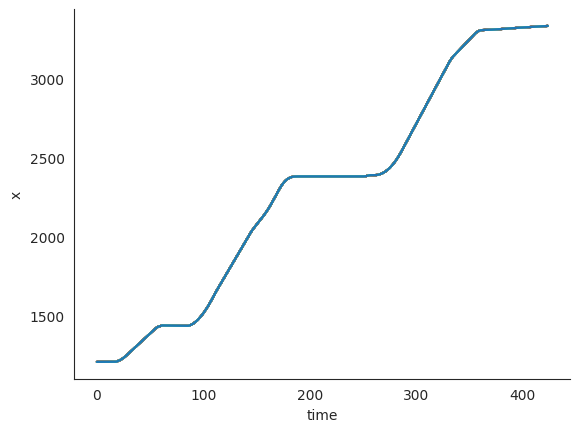

In [69]:
# Plot each noise column
for column in df_unattacked.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  plt.plot(range(0, len(df_unattacked)), df_unattacked[column], label=column)

# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

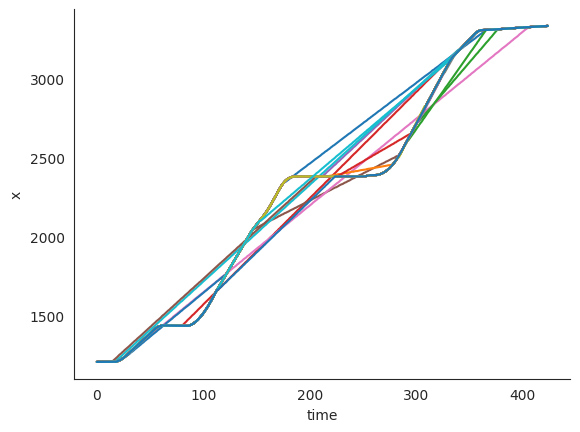

In [70]:
# Plot each noise column
for column in df_x.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  plt.plot(range(0, len(df_x)), df_x[column], label=column)

# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

In [71]:
# To identify attacked sensors
def get_difference_and_remove_margin_value_training(sensor_training, sensor_testing, percentile=95):
    difference_training = []
    difference_testing = []
    for i in range(len(sensor_training) - 1):
        difference1 = (sensor_training[i + 1] - sensor_training[0])/sensor_training[0]
        difference_training.append(difference1)
    difference_training = np.array(difference_training)

    for i in range(len(sensor_testing) - 1):
        difference2 = (sensor_testing[i + 1] - sensor_testing[0])/sensor_testing[0]
        difference_testing.append(difference2)
    difference_testing = np.array(difference_testing)

    # Compute the 95% quantile of difference_training
    # percentile = percentile
    d2 = np.percentile(difference_training, 100 - (100-percentile)/2)
    d1 = np.percentile(difference_training, 0+(100-percentile)/2)
    # Filter out values in difference_testing that fall within [-d, d]
    mask = np.logical_and(difference_testing >= d1, difference_testing <= d2)
    Difference_after_remove = difference_testing[mask]

    # Obtain the indices of the remaining values
    indices_after_remove = np.where(mask)[0]

    return Difference_after_remove, indices_after_remove

#### Train the SAITs for missing value imputation

In [14]:
pip install pypots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 2.2 MB/s eta 0:00:00


In [45]:
# Install PyPOTS first: pip install pypots==0.1.1
import numpy as np
from sklearn.preprocessing import StandardScaler
from pypots.data import load_specific_dataset, mcar, masked_fill
from pypots.imputation import SAITS
from pypots.utils.metrics import cal_mae


In [60]:
# Data preprocessing. Tedious, but PyPOTS can help.
# data = load_specific_dataset('physionet_2012')  # For datasets in PyPOTS database, PyPOTS will automatically download and extract it.
X = df_unattacked[:10000].to_numpy()

timesteps = 1
features = len(df_unattacked.columns)

number_of_samples = X.shape[0] // timesteps

X = X[:number_of_samples * timesteps, :].reshape(number_of_samples, timesteps, features)

X_intact, X, missing_mask, indicating_mask = mcar(X, 0.20) # hold out 10% observed values as ground truth
X = masked_fill(X, 1 - missing_mask, np.nan)

In [61]:
# Model training. This is PyPOTS showtime.
saits = SAITS(n_steps=timesteps, n_features=features, n_layers=2, d_model=256, d_inner=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=2000)
dataset = {"X": X}
saits.fit(dataset)  # train the model. Here I use the whole dataset as the training set, because ground truth is not visible to the model.
imputation = saits.impute(dataset)  # impute the originally-missing values and artificially-missing values
mae = cal_mae(imputation, X_intact, indicating_mask)  # calculate mean absolute error on the ground truth (artificially-missing values)

2023-08-06 16:29:59 [INFO]: No given device, using default device: cpu
2023-08-06 16:29:59 [INFO]: saving_path not given. Model files and tensorboard file will not be saved.
2023-08-06 16:29:59 [INFO]: Model initialized successfully with the number of trainable parameters: 1,383,407
2023-08-06 16:30:00 [INFO]: epoch 0: training loss 2817.1780
2023-08-06 16:30:01 [INFO]: epoch 1: training loss 1071.2462
2023-08-06 16:30:02 [INFO]: epoch 2: training loss 591.8412
2023-08-06 16:30:03 [INFO]: epoch 3: training loss 387.2557
2023-08-06 16:30:04 [INFO]: epoch 4: training loss 340.0035
2023-08-06 16:30:05 [INFO]: epoch 5: training loss 323.5258
2023-08-06 16:30:06 [INFO]: epoch 6: training loss 291.3893
2023-08-06 16:30:06 [INFO]: epoch 7: training loss 276.0113
2023-08-06 16:30:07 [INFO]: epoch 8: training loss 263.3564
2023-08-06 16:30:07 [INFO]: epoch 9: training loss 244.2879
2023-08-06 16:30:08 [INFO]: epoch 10: training loss 262.7500
2023-08-06 16:30:08 [INFO]: epoch 11: training loss 2

In [ ]:
# FSPM (Fusion ) model

def partition_dataset(sequence_length, data):
    data = StandardScaler().fit_transform(data)
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, 0]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(20, df_unattacked)

# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')


# Training the model
epochs = 500
batch_size = 64
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[early_stop]
                   )

                    #callbacks=[early_stop])

In [94]:
df = df_x.copy(deep=True)
  # df = df.drop(columns = ['time'])
for i in range(1, len(df)+1):


  timestep = df[i-1:i]

  old_stdout = sys.stdout # backup current stdout
  sys.stdout = open(os.devnull, "w")
  # label_attack = get_difference_and_remove_margin_value(np.array(df[i-1:i]).flatten(), percentile_level = 0.95)[1]
  label_attack = get_difference_and_remove_margin_value_training(np.array(df_unattacked[0:1]).flatten(), np.array(df[i-1:i]).flatten(), 90)[1]
  label_attack_95 = list(map(lambda l : l + 1, label_attack))

  # label_attack = find_attacked_sensor(np.array(df[1:2]).flatten(), np.array(df[i:i+1]).flatten(), np.array(df[1:2]).flatten()[0], mean=0, std=0.1, sample_size1=7, sample_size2=7, percentile_level=0.95)[2]
  # label_attack = label_attack + label_attack_95
  sys.stdout = old_stdout # reset old stdout
  m = list(set(range(1,40)).difference(label_attack_95))

  df[i-1:i].iloc[:, m] = np.nan

  # Imputing Nan with SAITs
  # if i % timesteps == 0 :
  #   X = df[i-timesteps:i].to_numpy()

  #   X = X[:1 * timesteps, :].reshape(1, timesteps, features)

  #   dataset = {"X": X}
  #   imputation = saits.impute(dataset)

  #   df[i-timesteps:i] = pd.DataFrame(imputation.reshape(-1, X.shape[-1]))



<ipython-input-94-69bac6df2de3>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i-1:i].iloc[:, m] = np.nan


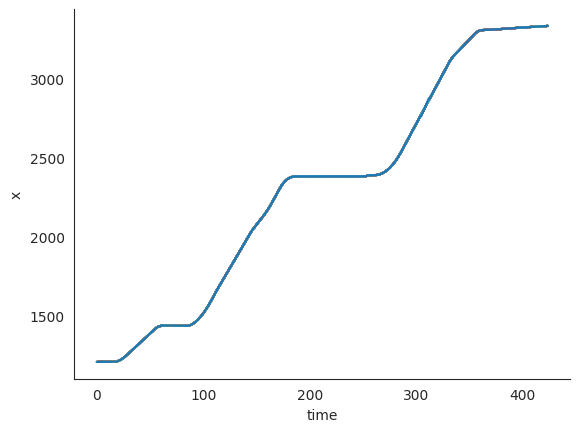

In [95]:
# Plot each noise column
for column in df.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  plt.plot(range(0, len(df)), df[column], label=column)

# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

In [83]:
# End to End point prediction

def fspm(data = df_x):

  df = data.copy(deep=True)
  # df = df.drop(columns = ['time'])
  for i in range(1, len(df)+1):


    timestep = df[i-1:i]

    old_stdout = sys.stdout # backup current stdout
    sys.stdout = open(os.devnull, "w")
    # label_attack = get_difference_and_remove_margin_value(np.array(df[i-1:i]).flatten(), percentile_level = 0.95)[1]
    label_attack = get_difference_and_remove_margin_value_training(np.array(df_unattacked[0:1]).flatten(), np.array(df[i-1:i]).flatten(), 95)[1]
    label_attack_95 = list(map(lambda l : l + 1, label_attack))

    # label_attack = find_attacked_sensor(np.array(df[1:2]).flatten(), np.array(df[i:i+1]).flatten(), np.array(df[1:2]).flatten()[0], mean=0, std=0.1, sample_size1=7, sample_size2=7, percentile_level=0.95)[2]
    # label_attack = label_attack + label_attack_95
    sys.stdout = old_stdout # reset old stdout
    m = list(set(range(1,40)).difference(label_attack_95))

    df[i-1:i].iloc[:, m] = np.nan

    df_after_attack_iden = df.copy(deep=True)

    # Imputing Nan with SAITs
    if i % timesteps == 0 :
      X = df[i-timesteps:i].to_numpy()

      X = X[:1 * timesteps, :].reshape(1, timesteps, features)

      dataset = {"X": X}
      imputation = saits.impute(dataset)

      df[i-timesteps:i] = pd.DataFrame(imputation.reshape(-1, X.shape[-1]))

  df_after_missing_value_imp = df.copy(deep=True)

  # Create scaled df for FSPM
  x_test, y_test = partition_dataset(20, df)
  # Make Predictions
  pred = model.predict(x_test)
  # Create the scaler object
  scaler = StandardScaler()
  # Fit the scaler to your original data to compute the mean and standard deviation
  scaler.fit(df)
  pred_reshaped = np.repeat(pred, df.shape[1], axis=1)
  # Use the inverse_transform() method to obtain the original values from the scaled data
  data_original = scaler.inverse_transform(pred_reshaped)

  final_predictions = pd.DataFrame(data_original).iloc[:,0]

  return df_after_attack_iden, df_after_missing_value_imp , final_predictions
  # return df

In [84]:
# df_after_attack_iden, df_after_missing_value_imp, final_predictions = fspm(data = df_x)

df_after_attack_iden, df_after_missing_value_imp , final_predictions = fspm(data = df_x)

<ipython-input-83-01eb231ce441>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i-1:i].iloc[:, m] = np.nan


13/13 [==============================] - 4s 332ms/step


In [ ]:
# Plot each noise column
for column in final_predictions.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  plt.plot(range(0, len(final_predictions)), final_predictions[column], label=column)

# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

In [87]:
final_predictions.shape

(405,)

#### Make multiple estimate for different instances of attacks using a single path

In [85]:
monte_carlo_runs = 10
estimations = pd.DataFrame()

In [86]:
for i in range(1, monte_carlo_runs):
  df_un, df_unattacked, df_x = create_sensor_data()
  df_after_attack_iden, df_after_missing_value_imp, final_predictions = fspm(data = df_x)

  estimations = estimations.append(final_predictions)

<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-83-01eb231ce441>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

13/13 [==============================] - 4s 336ms/step


<ipython-input-86-c2e34a024fdf>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-83-01eb231ce441>:23: SettingWit

13/13 [==============================] - 9s 680ms/step


<ipython-input-86-c2e34a024fdf>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-83-01eb231ce441>:23: SettingWit

13/13 [==============================] - 6s 492ms/step


<ipython-input-86-c2e34a024fdf>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-83-01eb231ce441>:23: SettingWit

13/13 [==============================] - 5s 348ms/step


<ipython-input-86-c2e34a024fdf>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-83-01eb231ce441>:23: SettingWit

13/13 [==============================] - 6s 422ms/step


<ipython-input-86-c2e34a024fdf>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  estimations = estimations.append(final_predictions)
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise
<ipython-input-54-8c634d9f69b6>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_un[column_name] = df_un['x'] + noise


ZeroDivisionError: ignored

In [89]:
predictions = estimations.transpose()

In [90]:
predictions.shape

(405, 5)

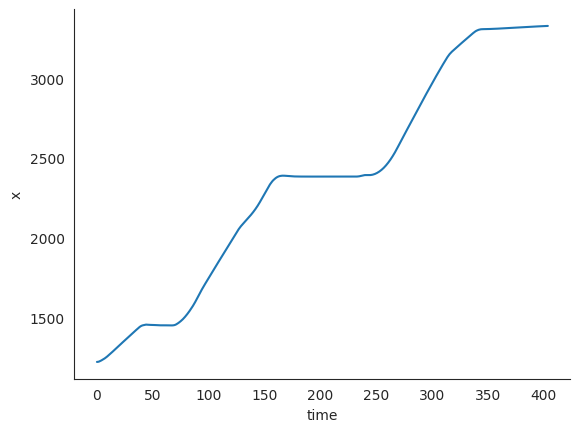

In [91]:
plt.plot(range(0, len(predictions.iloc[:,0])), predictions.iloc[:,0], label=column)
# Add labels and legend
plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()

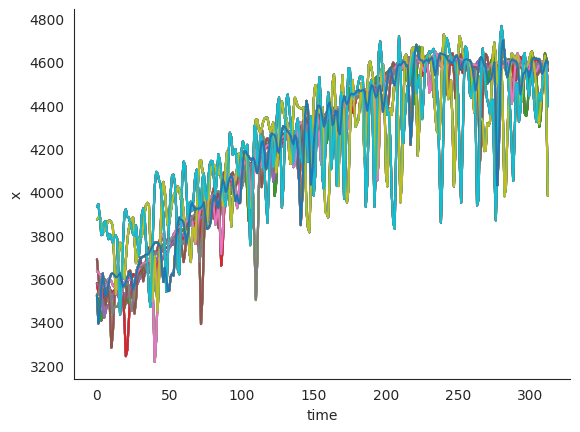

In [123]:
# Plot each noise column
for column in predictions.columns:
  # color_values = df['vehicle_id'].map({'red': 'r', 'green': 'g', 'blue': 'b'})
  # plt.figure()
  plt.plot(range(0, len(predictions)), predictions[column], label=column)
  # Add labels and legend

plt.xlabel('time')
plt.ylabel('x')
# plt.legend()

# Show the plot
plt.show()
